# Conjugate-Computational Variational Message Passing (CVI)

In [2]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate();

In [2]:
using RxInfer, Random, LinearAlgebra, Plots, Optimisers, Plots, StableRNGs, SpecialFunctions

In this notebook, the usage of Conjugate-NonConjugate Variational Inference (CVI) will be described. The implementation of CVI follows the paper [Probabilistic programming with stochastic variational message passing](https://reader.elsevier.com/reader/sd/pii/S0888613X22000950?token=EFB22E01793BD0BF73EECC9702C315644969403BD44B13FA850E9F66C8A49E88C0D5C68A9AD03301C609DA443DB33F80&originRegion=eu-west-1&originCreation=20221027115856).

This notebook will first describe an example in which CVI is used, then it discusses several limitations, followed by an explanation on how to extend upon CVI.

## An example: nonlinear dynamical system

A group of researchers is performing a tracking experiment on some moving object along a 1-dimensional trajectory. The object is moving at a constant velocity, meaning that its position increases constantly over time. However, the researchers do not have access to the absolute position $z_t$ at time $t$. Instead they have access to the observed squared distance $y_t$ between the object and some reference point $s$. Because of budget cuts, the servo moving the object and the measurement devices are quite outdated and therefore lead to noisy measurements:

In [3]:
# data generating process
nr_observations = 50
reference_point = 53
hidden_location = collect(1:nr_observations) + rand(StableRNG(124), NormalMeanVariance(0.0, sqrt(5)), nr_observations)
measurements = (hidden_location .- reference_point).^2 + rand(MersenneTwister(124), NormalMeanVariance(0.0, 5), nr_observations);

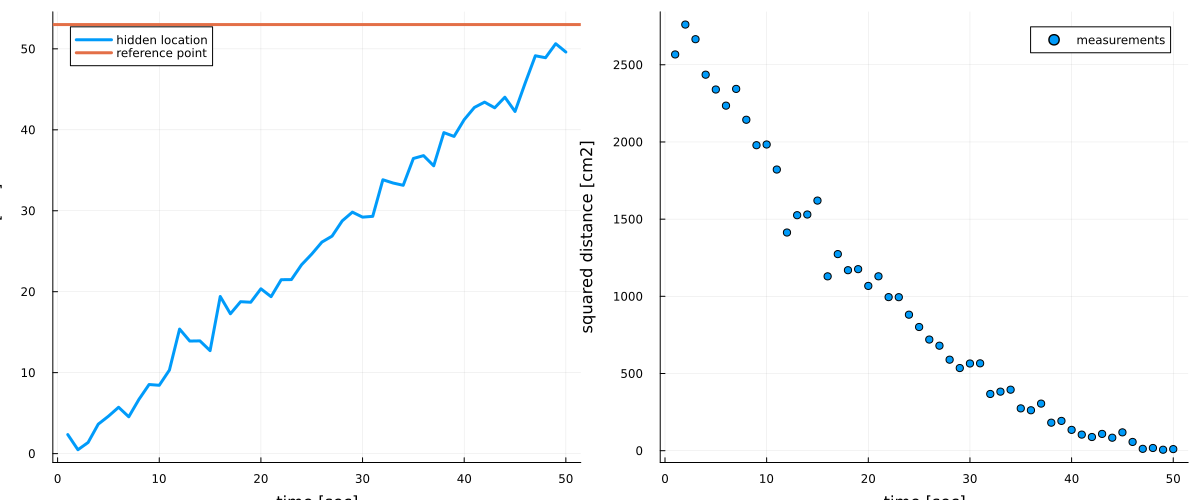

In [4]:
# plot hidden location and reference frame
p1 = plot(1:nr_observations, hidden_location, linewidth=3, legend=:topleft, label="hidden location")
hline!([reference_point], linewidth=3, label="reference point")
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot measurements
p2 = scatter(1:nr_observations, measurements, linewidth=3, label="measurements")
xlabel!("time [sec]"), ylabel!("squared distance [cm2]")

plot(p1, p2, size=(1200, 500))

The researchers are interested in quantifying this noise and in tracking the unobserved location of the object. As a result of this uncertainty, the researchers employ a probabilistic modeling approach. They formulate the probabilistic model

$$\begin{aligned}
 p(\tau) & = \Gamma(\tau \mid \alpha_{\tau}, \beta_{\tau}),\\
 p(\gamma) & = \Gamma(\gamma \mid \alpha_{\gamma}, \beta_{\gamma}),\\
 p(z_t \mid z_{t - 1}, \tau) & = \mathcal{N}(z_t \mid z_{t - 1} + 1, \tau^{-1}),\\
 p(y_t \mid z_t, \gamma) & = \mathcal{N}(y_t \mid (z_t - s)^2, \gamma^{-1}),
\end{aligned}$$
where the researchers put priors on the process and measurement noise parameters, $\tau$ and $\gamma$, respectively. They do this, because they do not know the accuracy of their devices.

The researchers have recently heard of this cool probabilistic programming package `RxInfer.jl`. They decided to give it a try and create the above model as follows:

In [5]:
function compute_squared_distance(z)
    (z - reference_point)^2
end;

In [6]:
@model function measurement_model(y)

    # set priors on precision parameters
    τ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    γ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    
    # specify estimate of initial location
    z[1] ~ Normal(mean = 0, precision = τ)
    y[1] ~ Normal(mean = compute_squared_distance(z[1]), precision = γ)

    # loop over observations
    for t in 2:length(y)

        # specify state transition model
        z[t] ~ Normal(mean = z[t-1] + 1, precision = τ)

        # specify non-linear observation model
        y[t] ~ Normal(mean = compute_squared_distance(z[t]), precision = γ)
        
    end

end

But here is the problem, our `compute_squared_distance` function is already compelx enough such that the exact Bayesian inference is intractable in this model. But the researchers knew that the `RxInfer.jl` supports a various collection of approximation methods for exactly such cases. One of these approximations is called CVI. CVI allows us to perform probabilistic inference around the non-linear measurement function. In general, for any (non-)linear relationship `y = f(x1, x2, ..., xN)` CVI can be employed, by specifying the function `f` and by adding this relationship inside the `@model` macro as `y ~ f(x1, x2, ...,xN)`. The `@model` macro will generate a factor node with node function `p(y | x1, x2, ..., xN) = δ(y - f(x1, x2, ...,xN))`.

The use of this non-linearity requires us to specify that we would like to use CVI. This can be done by specifying the metadata using the `@meta` macro as:

In [7]:
@meta function measurement_meta(rng, nr_samples, nr_iterations, optimizer)
    compute_squared_distance() -> CVI(rng, nr_samples, nr_iterations, optimizer)
end;

In general, for any (non-)linear function `f()`, CVI can be enabled with the `@meta` macro as:

```julia
@meta function model_meta(...)
    f() -> CVI(args...)
end
```

See `?CVI` for more information about the `args...`.

In our model, the `z` variables are connected to the non-linear node function. So in order to run probabilstic inference with `CVI` we need to enforce a constraint on the joint posterior distribution. Specifically, we need to create a factorization in which the variables that are directly connected to non-linearities are assumed to be independent from the rest of the variables.

In the above example, we will assume the following posterior factorization:

In [8]:
@constraints function measurement_constraints()
    q(z, τ, γ) = q(z)q(τ)q(γ)
end;

This constraint can be explained by the set of two constraints, one for getting CVI to run, and one for assuming a mean-field factorization around the normal node as 
```julia
@constraints function posterior_constraints() begin
    q(z, γ) = q(z)q(γ) # CVI
    q(z, τ) = q(z)q(τ) # the mean-field assumption around normal node
end
```

Because the engineers are using `RxInfer.jl`, they can automate the inference procedure. They track the inference performance using the Bethe free energy.

In [11]:
results = infer(
    model = measurement_model(),
    data = (y = measurements,),
    iterations = 5,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 100, 200, Optimisers.Descent(0.01)),
    initmessages = (z = NormalMeanVariance(0, 5),),
    initmarginals = (z = NormalMeanVariance(0, 5), τ = GammaShapeRate(1.0, 1.0e-12), γ = GammaShapeRate(1.0, 1.0e-12),),
)

Inference results:
  Posteriors       | available for (z)
  Free Energy:     | Real[1241.91, 429.933, 376.869, 365.774, 362.879]


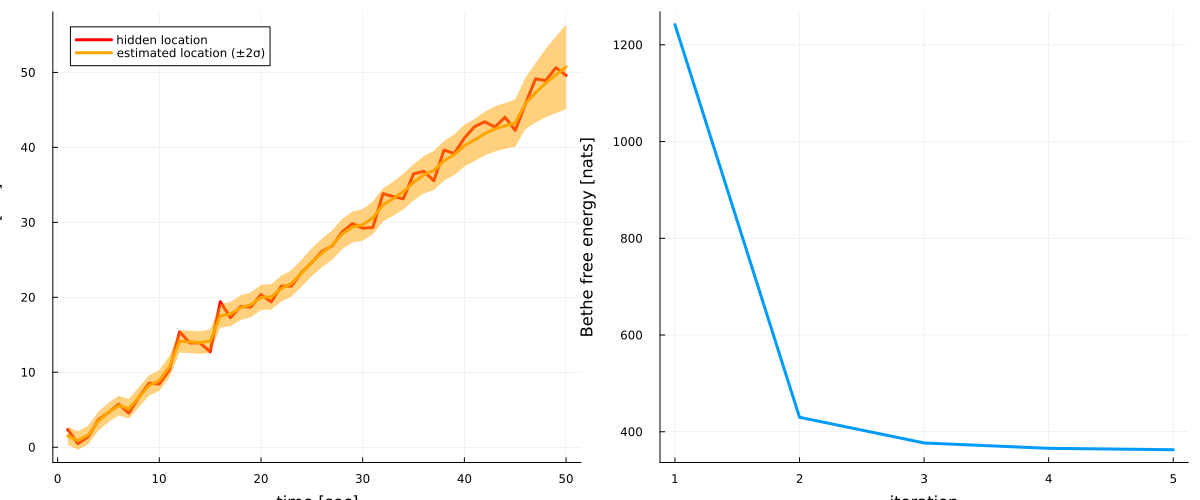

In [12]:
# plot estimates for location
p1 = plot(collect(1:nr_observations), hidden_location, label = "hidden location", legend=:topleft, linewidth=3, color = :red)
plot!(map(mean, results.posteriors[:z]), label = "estimated location (±2σ)", ribbon = map(x -> 2*std(x), results.posteriors[:z]), fillalpha=0.5, linewidth=3, color = :orange)
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot Bethe free energy
p2 = plot(results.free_energy, linewidth=3, label = "")
xlabel!("iteration"), ylabel!("Bethe free energy [nats]")

plot(p1, p2, size = (1200, 500))

## Requirements

There are several main requirements for the `CVI` procedure to satisfy:
1. The `out` interface of the non-linearity must be independently factorized with respect to other variables in the model.
2. The messages on input interfaces (`x1, x2, ..., xN`) are required to be from the exponential family of distributions.

In `RxInfer`, you can satisfy the first requirement by using appropriate factor nodes (`Normal`, `Gamma`, `Bernoulli`, etc) and second requirement by specifying the `@constraints` macro. In general you can specify this procedure as

```julia
@model function model(...)
    ...
    y ~ f(x1, x2, ..., xN)
    ... ~ Node2(z1,..., y, zM) # some node that is using the out interface of the non-linearity
    ... 
end

@constraints function constraints_meta() begin
    q(y, z1, ..., zn) = q(y)q(z1,...,zM)
    ...
end;

@meta function model_meta(...)
    f() -> CVI(rng, nr_samples, nr_iterations, optimizer))
end
```

Note that not all exponential family distributions are implemented.

## Extensions

### Using a custom optimizer

`CVI` only supports `Optimisers` optimizers out of the box.

Below an explanation on how to extend to it to a custom optimizer.

Suppose we have `CustomDescent` structure which we want to use inside `CVI` for optimization.

To do so, we need to implement `ReactiveMP.cvi_update!(opt::CustomDescent, λ, ∇)`.

`ReactiveMP.cvi_update!` incapsulates the gradient step:
1. `opt` is used to select your optimizer structure
2. `λ` is the current value
3. `∇` is a gradient value computed inside `CVI`.

In [13]:
struct CustomDescent 
    learning_rate::Float64
end

# Must return an optimizer and its initial state
function ReactiveMP.cvi_setup(opt::CustomDescent, q)
     return (opt, nothing)
end

# Must return an updated (opt, state) and an updated λ (can use new_λ for inplace operation)
function ReactiveMP.cvi_update!(opt_and_state::Tuple{CustomDescent, Nothing}, new_λ, λ, ∇)
    opt, _ = opt_and_state
    λ̂ = vec(λ) - (opt.learning_rate .* vec(∇))
    copyto!(new_λ, λ̂)
    return opt_and_state, new_λ
end

Let's try to apply it to a model:
$$\begin{aligned}
 p(x) & = \mathcal{N}(0, 1),\\
 p(y_{i}\mid x) & = \mathcal{N}(y_i \mid x^2, 1),\\
\end{aligned}$$

Let's generate some synthetic data for the model

In [1]:
# generate data
y = rand(StableRNG(123), NormalMeanVariance(19^2, 1), 1000)
histogram(y)

UndefVarError: UndefVarError: `StableRNG` not defined

Again we can create the corresponding model as:

In [15]:
# specify non-linearity
f(x) = x ^ 2

# specify model
@model function normal_square_model(y)

    # describe prior on latent state
    x ~ NormalMeanPrecision(0, 100)

    # transform latent state
    mean ~ f(x)

    # observation model
    y .~ NormalMeanVariance(mean, 1)

end

# specify meta
@meta function normal_square_meta(rng, nr_samples, nr_iterations, optimizer)
    f() ->  CVI(rng, nr_samples, nr_iterations, optimizer)
end

normal_square_meta (generic function with 1 method)

We will use the `inference` function from `ReactiveMP` to run inference, where we provide an instance of the `CustomDescent` structure in our `meta` macro function:

**Side note**:
To run the inference for this model, we do not need to init the message for `x` but with this initialization, the inference procedure is more stable.

In [17]:
res = infer(
    model = normal_square_model(),
    data = (y = y,),
    iterations = 10,
    free_energy = true,
    initmessages = (x = NormalMeanVariance(0, 100),),
    meta = normal_square_meta(StableRNG(123), 100, 100, CustomDescent(0.1))
)

mean(res.posteriors[:x][end])

-18.998075156688632

The mean inferred value of `x` is indeed close to `19`, which was used to generate the data. Inference is working! 

**Note**: 
$x^2$ can not be inverted; the sign information can be lost: -19 and 19 are both equally good solutions.